In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [6]:
data = pd.read_csv('SCMS_Delivery_History_Dataset (1).csv')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

In [8]:
#Preprocessing

def preprocess_inputs(df, label_mapping):
    df = df.copy()
    
    # Drop ID column
    df = df.drop('ID', axis=1)
    
    # Drop missing target rows
    missing_target_rows = df[df['Shipment Mode'].isna()].index
    df = df.drop(missing_target_rows, axis=0).reset_index(drop=True)
    
    # Fill missing values
    df['Dosage'] = df['Dosage'].fillna(df['Dosage'].mode()[0])
    df['Line Item Insurance (USD)'] = df['Line Item Insurance (USD)'].fillna(df['Line Item Insurance (USD)'].mean())
    
    # Drop date columns with too many missing values
    df = df.drop(['PQ First Sent to Client Date', 'PO Sent to Vendor Date'], axis=1)
    
    # Extract date features
    for column in ['Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date']:
        df[column] = pd.to_datetime(df[column])
        df[column + ' Year'] = df[column].apply(lambda x: x.year)
        df[column + ' Month'] = df[column].apply(lambda x: x.month)
        df[column + ' Day'] = df[column].apply(lambda x: x.day)
        df = df.drop(column, axis=1)
    
    # Drop numeric columns with too many missing values
    df = df.drop(['Weight (Kilograms)', 'Freight Cost (USD)'], axis=1)
    
    # Drop high-cardinality columns
    df = df.drop(['PQ #', 'PO / SO #', 'ASN/DN #'], axis=1)
    
    # Binary encoding
    df['Fulfill Via'] = df['Fulfill Via'].replace({'Direct Drop': 0, 'From RDC': 1})
    df['First Line Designation'] = df['First Line Designation'].replace({'No': 0, 'Yes': 1})
    
    # One-hot encoding
    for column in df.select_dtypes('object').columns.drop('Shipment Mode'):
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    
    # Split df into X and y
    y = df['Shipment Mode']
    X = df.drop('Shipment Mode', axis=1)
    
    # Encode the labels
    y = y.replace(label_mapping)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [9]:
LABEL_MAPPING = {
    'Air': 0,
    'Truck': 1,
    'Air Charter': 2,
    'Ocean': 3
}

X_train, X_test, y_train, y_test = preprocess_inputs(data, label_mapping=LABEL_MAPPING)

In [10]:
X_train

,Fulfill Via,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,First Line Designation,Line Item Insurance (USD),Scheduled Delivery Date Year,Scheduled Delivery Date Month,...,Manufacturing Site_Ranbaxy per Shasun Pharma Ltd,"Manufacturing Site_Ranbaxy, Paonta Shahib, India","Manufacturing Site_Remedica, Limassol, Cyprus",Manufacturing Site_Roche Basel,Manufacturing Site_Roche Madrid,"Manufacturing Site_Standard Diagnostics, Korea","Manufacturing Site_Strides, Bangalore, India.","Manufacturing Site_Trinity Biotech, Plc","Manufacturing Site_Weifa A.S., Hausmanngt. 6, P.O. Box 9113 GrÃ¸nland, 0133, Oslo, Norway",Manufacturing Site_bioLytical Laboratories
8905,0.975074,-0.228739,-0.426393,-0.442833,-0.365576,-0.221030,0.673216,-0.471452,1.087860,0.760567,...,-0.011975,-0.057523,-0.011975,-0.058764,-0.031698,-0.102136,-0.242388,-0.197963,-0.011975,-0.023956
1414,0.975074,-0.228739,0.198248,0.418854,-0.218907,-0.172736,0.673216,0.702302,-0.994006,0.456201,...,-0.011975,-0.057523,-0.011975,-0.058764,-0.031698,-0.102136,-0.242388,-0.197963,-0.011975,-0.023956
1409,0.975074,-0.228739,0.532553,0.366882,-0.309884,-0.203468,0.673216,0.632237,-0.994006,-0.152532,...,-0.011975,-0.057523,-0.011975,-0.058764,-0.031698,-0.102136,4.125612,-0.197963,-0.011975,-0.023956
874,-1.025563,0.291362,-0.450154,-0.274234,2.493413,0.354098,0.673216,-0.278564,-1.410379,-1.674365,...,-0.011975,-0.057523,-0.011975,-0.058764,-0.031698,-0.102136,-0.242388,5.051446,-0.011975,-0.023956
1941,0.975074,-0.618816,0.159722,0.338381,-0.227409,-0.093711,0.673216,0.593803,-0.994006,-0.456899,...,-0.011975,-0.057523,-0.011975,-0.058764,-0.031698,-0.102136,-0.242388,-0.197963,-0.011975,-0.023956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,-1.025563,-0.228739,-0.407975,-0.436590,-0.377267,-0.225420,-1.485408,-0.467031,1.087860,1.064934,...,-0.011975,-0.057523,-0.011975,-0.058764,-0.031698,-0.102136,-0.242388,-0.197963,-0.011975,-0.023956
7813,0.975074,-0.228739,-0.005566,-0.331187,-0.409364,-0.238591,0.673216,-0.358993,0.255114,0.760567,...,-0.011975,-0.057523,-0.011975,-0.058764,-0.031698,-0.102136,-0.242388,-0.197963,-0.011975,-0.023956
905,-1.025563,-0.618816,1.611276,2.247912,-0.223796,-0.093711,0.673216,2.497515,-1.410379,0.760567,...,-0.011975,-0.057523,-0.011975,-0.058764,-0.031698,-0.102136,-0.242388,-0.197963,-0.011975,-0.023956
5192,-1.025563,0.291362,-0.281635,1.413370,1.430592,0.134584,0.673216,2.296044,-0.577633,1.369300,...,-0.011975,-0.057523,-0.011975,-0.058764,-0.031698,-0.102136,-0.242388,-0.197963,-0.011975,-0.023956


In [11]:
y_train.value_counts()

0    4317
1    1950
2     449
3     258
Name: Shipment Mode, dtype: int64

In [12]:
inputs = tf.keras.Input(shape=(771,))
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7398 - loss: 0.6575 - val_accuracy: 0.8810 - val_loss: 0.3041
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9106 - loss: 0.2252 - val_accuracy: 0.8846 - val_loss: 0.3042
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9241 - loss: 0.1877 - val_accuracy: 0.8789 - val_loss: 0.2979
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9245 - loss: 0.1811 - val_accuracy: 0.8860 - val_loss: 0.2971
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9319 - loss: 0.1558 - val_accuracy: 0.8810 - val_loss: 0.3074
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9371 - loss: 0.1521 - val_accuracy: 0.8839 - val_loss: 0.2880
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9459 - loss: 0.1313 - val_accuracy: 0.8932 - val_loss: 0.2895
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9465 - loss: 0.1272 - val_accu

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
Test Set Accuracy: 89.43%


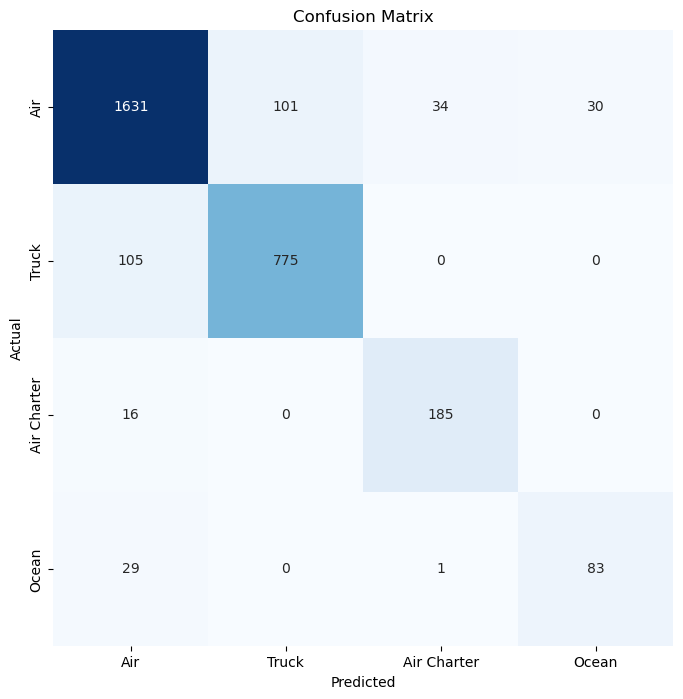

Classification Report:
----------------------
               precision    recall  f1-score   support

         Air       0.92      0.91      0.91      1796
       Truck       0.88      0.88      0.88       880
 Air Charter       0.84      0.92      0.88       201
       Ocean       0.73      0.73      0.73       113

    accuracy                           0.89      2990
   macro avg       0.84      0.86      0.85      2990
weighted avg       0.89      0.89      0.89      2990



In [13]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred, labels=list(LABEL_MAPPING.values()))
clr = classification_report(y_test, y_pred, labels=list(LABEL_MAPPING.values()), target_names=list(LABEL_MAPPING.keys()))

print("Test Set Accuracy: {:.2f}%".format(model.evaluate(X_test, y_test, verbose=0)[1] * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=list(LABEL_MAPPING.keys()))
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=list(LABEL_MAPPING.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)